In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pysal as ps

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/citi_docks2/citi_docks2.shp')
df = df.dropna()
df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers
0,37.500000,751.750000,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,5223,510.500000,39.500000,1561.000000,232.000000,302.0,0,0.528303,24.555556
1,0.000000,636.500000,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,14647,342.500000,112.500000,1043.000000,163.958333,488.0,9,0.217273,256.000000
2,7.666667,407.000000,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,8616,112.000000,166.333333,857.000000,206.666667,502.0,0,0.426971,31.166667
3,14.333333,840.666667,1.032838,1.624516,POINT (990973.8184738184 206381.12757902),62840.000000,8969,584.333333,4.000000,1745.333333,346.166667,487.0,0,0.344071,4.000000
4,12.250000,647.500000,3.216434,1.936163,POINT (983426.5668231647 204179.6463416842),75221.250000,14414,465.750000,118.500000,1062.000000,130.308333,128.0,11,0.072636,129.460417


In [3]:
# combine no vehicle units into one column
df['no_vehicle'] = df['no_vehic_1'] + df['no_vehicle']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['dist_towor2'] = df['dist_towor']**2
df['log_workers'] = np.log10(df['workers'])
df['log_residents'] = np.log10(df['residents'])
df['log_rides'] = np.log10(df['n_rides'])

# get rid of outlier
df = df[df['n_rides'] < 50000]
df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,dist_towor2,log_workers,log_residents,log_rides
0,37.500000,751.750000,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,5223,510.500000,550.000000,1561.000000,232.000000,302.0,0,0.528303,24.555556,8.410180,4.040088,1.390150,2.365488,3.717920
1,0.000000,636.500000,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,14647,342.500000,455.000000,1043.000000,163.958333,488.0,9,0.217273,256.000000,11.161296,1.542129,2.408240,2.214733,4.165749
2,7.666667,407.000000,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,8616,112.000000,278.333333,857.000000,206.666667,502.0,0,0.426971,31.166667,9.820103,5.672167,1.493690,2.315270,3.935306
3,14.333333,840.666667,1.032838,1.624516,POINT (990973.8184738184 206381.12757902),62840.000000,8969,584.333333,588.333333,1745.333333,346.166667,487.0,0,0.344071,4.000000,1.066754,2.639053,0.602060,2.539285,3.952744
4,12.250000,647.500000,3.216434,1.936163,POINT (983426.5668231647 204179.6463416842),75221.250000,14414,465.750000,584.250000,1062.000000,130.308333,128.0,11,0.072636,129.460417,10.345446,3.748727,2.112137,2.114972,4.158785


### Simple Model to test this LEHD OD value

In [4]:
lm = smf.ols('n_rides ~ dist_towor + dist_towor2 + dist_tohom + dist_tohom2', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     16.11
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           1.09e-11
Time:                        13:18:36   Log-Likelihood:                -2387.8
No. Observations:                 243   AIC:                             4786.
Df Residuals:                     238   BIC:                             4803.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    3540.5371   4294.889      0.824      0.411     -4920.316   1.2e+04
dist_towor    636.9305   4334.743      0.147      0.883     -7902.433  9176.294
dist_towor2 -1924.6416   1385.163     -1.389      0.166     -4653.387   804.103
dist_tohom   4753.4913   2362.705      2.012      0.045        99.006  9407.976
dist_tohom2  -309.3577    398.647     -0.776      0.439     -1094.685   475.970
==============================================================================
Omnibus:                       88.590   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.089
Skew:                           1.529   Prob(JB):                     1.53e-66
Kurtosis:                       7.537   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Extensive Model

In [5]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom + dist_tohom2 + subway_dis + bike + commute_ti + \
income_pc + no_vehicle + pop + residents + subway_ct + workers', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.945
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           1.04e-10
Time:                        13:18:36   Log-Likelihood:                -2379.3
No. Observations:                 243   AIC:                             4785.
Df Residuals:                     230   BIC:                             4830.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    3037.4403   4294.069      0.707      0.480     -5423.301  1.15e+04
dist_towor  -3543.3332   1127.109     -3.144      0.002     -5764.112 -1322.555
dist_tohom   7688.7605   2363.549      3.253      0.001      3031.784  1.23e+04
dist_tohom2  -990.6593    399.310     -2.481      0.014     -1777.433  -203.886
subway_dis  -9412.6111   3144.572     -2.993      0.003     -1.56e+04 -3216.761
bike           17.0207     20.651      0.824      0.411       -23.668    57.710
commute_ti      2.5994      2.578      1.008      0.314        -2.481     7.679
income_pc      -0.0044      0.009     -0.474      0.636        -0.023     0.014
no_vehicle     -1.6820      2.956     -0.569      0.570        -7.507     4.143
pop            -0.6918      1.147     -0.603      0.547        -2.951     1.568
residents       3.8284      2.736      1.399      0.163        -1.563     9.220
subway_ct     -18.1618     34.938     -0.520      0.604       -87.002    50.679
workers         2.0622      1.144      1.803      0.073        -0.191     4.315
==============================================================================
Omnibus:                       76.766   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.030
Skew:                           1.317   Prob(JB):                     6.89e-56
Kurtosis:                       7.260   Cond. No.                     1.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
df.corr()

,bike,commute_ti,dist_tohom,dist_towor,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,dist_towor2,log_workers,log_residents,log_rides
bike,1.000000,0.189034,-0.098763,0.177868,-0.228599,-0.119949,0.227250,0.217899,0.268240,0.226564,-0.087667,-0.339727,0.436616,-0.298959,-0.106292,0.125032,-0.364170,0.221471,-0.126680
commute_ti,0.189034,1.000000,0.492847,0.378959,0.131964,-0.017515,0.918961,0.956548,0.933437,0.239932,-0.038921,0.105714,0.049848,-0.180000,0.535651,0.374972,-0.024457,0.273425,0.011080
dist_tohom,-0.098763,0.492847,1.000000,0.578246,0.392971,0.067079,0.324602,0.378649,0.423849,-0.007325,-0.053999,0.359165,-0.214456,-0.066744,0.982820,0.629793,0.131785,-0.030375,0.097185
dist_towor,0.177868,0.378959,0.578246,1.000000,0.013336,-0.319429,0.278608,0.291705,0.462772,-0.028137,-0.042663,-0.060077,0.060367,-0.455966,0.632473,0.985715,-0.381323,-0.050608,-0.295823
income_pc,-0.228599,0.131964,0.392971,0.013336,1.000000,0.178064,-0.076612,0.043875,-0.026950,-0.160245,-0.025590,0.369078,-0.382281,0.137935,0.353894,0.036545,0.320110,-0.218528,0.167743
n_rides,-0.119949,-0.017515,0.067079,-0.319429,0.178064,1.000000,-0.037084,-0.024995,-0.111929,0.034033,-0.052819,0.238154,-0.268681,0.302348,0.015187,-0.310067,0.328413,0.054112,0.903203
no_vehic_1,0.227250,0.918961,0.324602,0.278608,-0.076612,-0.037084,1.000000,0.974587,0.873159,0.330200,-0.015924,-0.007712,0.172093,-0.186631,0.365563,0.264514,-0.089586,0.364712,0.002571
no_vehicle,0.217899,0.956548,0.378649,0.291705,0.043875,-0.024995,0.974587,1.000000,0.901072,0.301238,-0.040951,0.034046,0.121440,-0.201236,0.414586,0.277573,-0.065223,0.341216,0.011504
pop,0.268240,0.933437,0.423849,0.462772,-0.026950,-0.111929,0.873159,0.901072,1.000000,0.259501,-0.056328,-0.023205,0.193910,-0.266024,0.470019,0.438202,-0.162369,0.295001,-0.098736
residents,0.226564,0.239932,-0.007325,-0.028137,-0.160245,0.034033,0.330200,0.301238,0.259501,1.000000,0.125079,-0.213230,0.342235,-0.199975,-0.024132,-0.062211,-0.179842,0.934833,0.064297


This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

### Another model following simple feature selection

In [7]:
lm = smf.ols('n_rides ~ dist_towor + dist_towor2 + dist_tohom + subway_dis + workers + residents', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     14.71
Date:                Fri, 09 Dec 2016   Prob (F-statistic):           2.88e-14
Time:                        13:18:36   Log-Likelihood:                -2378.3
No. Observations:                 243   AIC:                             4771.
Df Residuals:                     236   BIC:                             4795.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -2110.8426   4541.614     -0.465      0.643     -1.11e+04  6836.441
dist_towor   1.096e+04   4688.827      2.336      0.020      1717.958  2.02e+04
dist_towor2 -4591.0704   1355.030     -3.388      0.001     -7260.570 -1921.571
dist_tohom   2465.0214    522.273      4.720      0.000      1436.109  3493.934
subway_dis  -7235.4638   2387.108     -3.031      0.003     -1.19e+04 -2532.702
workers         3.1694      1.159      2.735      0.007         0.886     5.452
residents       3.5226      2.584      1.363      0.174        -1.569     8.614
==============================================================================
Omnibus:                       86.823   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.172
Skew:                           1.471   Prob(JB):                     9.90e-69
Kurtosis:                       7.720   Cond. No.                     1.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

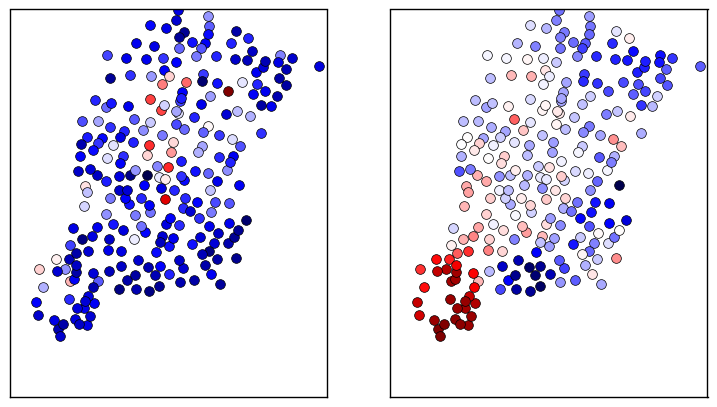

In [9]:
f1, ax = plt.subplots(ncols = 2, figsize=(9,5))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
df.plot(column = 'n_rides', cmap = 'seismic', ax = ax[0], markersize = 7)
df.plot(column = 'dist_tohom', cmap = 'seismic', ax = ax[1], markersize = 7)

In [10]:
# spatial regression

if not os.path.exists('data/for_sreg/'):
    os.makedirs('data/for_sreg/')
    
df.to_file('data/for_sreg/for_sreg.shp')

w = ps.knnW_from_shapefile('data/for_sreg/for_sreg.shp', k = 5)
sp_reg = ps.spreg.ML_Lag(df[['n_rides']].as_matrix(), df[['dist_towor', 'dist_towor2', 'dist_tohom', \
                                                          'subway_dis', 'workers', 'residents']].as_matrix(), w = w)
print sp_reg.summary

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         243
Mean dependent var  :  10242.8354                Number of Variables   :           8
S.D. dependent var  :   5060.0568                Degrees of Freedom    :         235
Pseudo R-squared    :      0.3395
Spatial Pseudo R-squared:  0.2754
Sigma-square ML     :16869672.750                Log likelihood        :   -2369.758
S.E of regression   :    4107.271                Akaike info criterion :    4755.516
                                                 Schwarz criterion     :    4783.460

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:599: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
